In [1]:
import sys
import os
import random
import time
import glob
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import auc as calc_auc
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import torchvision.transforms as transforms


from omegaconf import OmegaConf
from omegaconf import DictConfig

sys.path.append("/home/ngsci/project/tuberculosis_detection/03_training/hipt_stage3_on_embeddings_bag/")
from model_multiscale_mil_hipt_stage3 import HIPT_LGP_FC_STAGE3ONLY, Attn_Net_Gated

In [2]:
conf_preproc = OmegaConf.load("/home/ngsci/project/tuberculosis_detection/conf/preproc.yaml")
conf_train = OmegaConf.load("/home/ngsci/project/tuberculosis_detection/conf/train.yaml")

conf_preproc = conf_preproc["hipt_stage3_on_embeddings_bag"]["uni_224_224_patches"]
conf_train = conf_train["hipt_stage3_on_embeddings_bag"]["uni_224_224_patches"]

In [4]:
def create_balanced_bag_subset(labels, minority_class_ratio=0.2, rnd_seed=38):

    np.random.seed(rnd_seed)
    test_local_idx = []
    class_occurence = np.array(list(dict( Counter(labels) ).values()))[ np.argsort(list(dict( Counter(labels) ).keys()))]
    class_weights = ( class_occurence / class_occurence.sum() ).astype(np.float32)
    class_weights_dict = dict( zip( np.arange(class_weights.shape[0]), class_weights ))
    nr_class_test = int(labels.shape[0]*np.min(class_weights)*minority_class_ratio)

    for s in np.unique(labels): #loop over labelss
        s_idx = np.arange(labels.shape[0])[labels == s]
        rnd_idx = np.random.permutation(s_idx.shape[0])
        test_local_idx.append(s_idx[rnd_idx[:nr_class_test]])

    test_idx = np.concatenate(test_local_idx)
    
    random.Random(23).shuffle(test_idx) # shuffle otherwise lables are ordered
    train_idx = np.arange(labels.shape[0])[~np.in1d(np.arange(labels.shape[0]), test_idx)]
    
    return train_idx, test_idx

In [5]:
class h5_Dataset(Dataset):
    def __init__(self, emb_file, cv_df, transform=None):
        self.transform = transform
        self.file = emb_file 
        self.cv_df = cv_df
        self.dataset_name = 'features'
        self.cv_samples_index = np.array([ int(os.path.basename(f).replace(".jpg","").replace("tb",""))-1 for f in self.cv_df["file_path"] ])
        self.cv_idx_to_all_idx = dict(zip(np.arange(self.cv_samples_index.shape[0]), self.cv_samples_index))
        
    
    def __len__(self):
        return len(self.cv_samples_index)


    def __getitem__(self, idx):

        all_idx = self.cv_idx_to_all_idx[idx]
        # Open the file and get the image data
        with h5py.File(self.file, 'r') as in_h5:

            # Get the image data from the file
            image_data = in_h5[self.dataset_name][all_idx]
            label = in_h5["tb_positive"][all_idx]
            
            if self.transform:
                image_data = self.transform(image_data)
        
        return image_data, label

In [6]:
# not modified
def train_loop(cur, y_train_all, y_val_all, results_dir, 
               batch_size, num_epochs, model, n_classes, loss_fn=None, gc=32):  
            
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    print('\nInit optimizer ...', end=' ')

    weight_decay = conf_train.weight_decay
    
    if conf_train["use_scheduler"]:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.initial_lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=conf_train.eta_min)
        
    else:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.lr, weight_decay=weight_decay)
    
    print('Done!')
    
    train_loss_all_epoch = []
    val_loss_all_epoch = []
    val_auc_all_epoch = []
    val_prauc_all_epoch = []
    
    ## training and validation loops with balanced folds
    for epoch in range(0, num_epochs):
        print('EPOCH:', epoch)

        _, balance_idx, = create_balanced_bag_subset(y_train_all,
                                                     minority_class_ratio=conf_train.minority_class_ratio,
                                                     rnd_seed=int(epoch*1.5+3*epoch))
        
        # here actually getting the subset needed
        train_dataset = h5_Dataset(conf_preproc["emb_h5"], train_df.iloc[balance_idx])

        
        # create the pytorch data loader
        train_dataset_loader = torch.utils.data.DataLoader(train_dataset, 
                                                           batch_size=batch_size,
                                                           num_workers=1, shuffle=False)
        print('Train dataloader len:', len(train_dataset_loader))
        # init variables and set to training mode
        model.train()
        train_loss = 0.
        train_error = 0.
        
        # Iterate over data
        for (data, label) in tqdm(train_dataset_loader):
            data = data.to(device, dtype=torch.float, non_blocking=True)
            label = label.to(device, dtype=torch.long, non_blocking=True)
            
            logits, Y_prob, Y_hat, _, _ = model(data)

            loss = loss_fn(logits, label)
            loss_value = loss.item()

            train_loss += loss_value

            error = calculate_error(Y_hat, label)
            train_error += error

            loss = loss / gc
            loss.backward()

            # step
            optimizer.step()
            optimizer.zero_grad()
            
        if conf_train["use_scheduler"]:
            scheduler.step()

        # calculate loss and error for epoch
        train_loss /= len(train_dataset_loader)
        train_error /= len(train_dataset_loader)
        print('Train loss:', train_loss)
                

        ## VALIDATION
        
  
        val_dataset = h5_Dataset(conf_preproc["emb_h5"], val_df)

        # create the pytorch data loader
        val_dataset_loader = torch.utils.data.DataLoader(val_dataset, 
                                                         batch_size=batch_size, 
                                                         num_workers=1, shuffle=False)

        stop, val_loss_epoch, auc_epoch, prauc_epoch = validate( model, val_dataset_loader,
                                                                 n_classes, loss_fn, results_dir )

        os.makedirs(results_dir + f"cv_{cur}/", exist_ok=True)
        torch.save(model.state_dict(), os.path.join(results_dir, f"cv_{cur}", 
                                                    f"trainloss_{np.round(train_loss,4)}_valloss_{np.round(val_loss_epoch,4)}_auc_{np.round(auc_epoch,4)}_prauc_{np.round(prauc_epoch,4)}_"\
                                                    +"checkpoint.pt"))

        val_loss_all_epoch.append(val_loss_epoch)
        val_auc_all_epoch.append(auc_epoch)
        val_prauc_all_epoch.append(prauc_epoch)

        train_loss_all_epoch.append(train_loss)
    
    # Save training parameters to disk    
    param_dict = {'num_epochs': num_epochs,
                  'weight_decay': weight_decay,
                  'train_loss_all_epoch': train_loss_all_epoch,
                  'val_loss_all_epoch': val_loss_all_epoch,
                  'val_auc_all_epoch': val_auc_all_epoch,
                  'val_prauc_all_epoch': val_prauc_all_epoch}
 
    return param_dict

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # try to one-hot encode y_true
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 2)

    plt.figure(figsize=(4, 4))
    class_ind = 1 #for minority
    fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
    auc = roc_auc_score(y_true[:, class_ind], y_pred[:, class_ind])
    pr_auc = average_precision_score(y_true[:, class_ind], y_pred[:, class_ind])
    plt.plot(fpr, tpr, '-', label='ROC_AUC : %.3f, PR_AUC : %.3f' % (auc, pr_auc))
    
    plt.legend()
    plt.show()

In [8]:
def validate(model, loader, n_classes, loss_fn = None, results_dir=None):
    
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # init variables and set mode to evaluation
    model.eval()
    val_loss = 0.
    val_error = 0.
    
    # containers to store variables to evaluate predictions on VAL set
    prob = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):

            data, label = batch
            data = data.to(device, dtype=torch.float, non_blocking=True)
            label = label.to(device, dtype=torch.long, non_blocking=True)
            
            logits, Y_prob, Y_hat, _, _ = model(data)
            
            loss = loss_fn(logits, label)
            
            # save predictions for current batch
            prob.append(Y_prob.cpu().numpy())
            
            # save labels for current batch
            labels.append(label.cpu().numpy())
            
            val_loss += loss.item()
            error = calculate_error(Y_hat, label)
            val_error += error
            
    val_error /= len(loader)
    val_loss /= len(loader)
    
    prob = np.concatenate(prob)
    labels = np.concatenate(labels)

    if n_classes == 2:
        auc = roc_auc_score(labels, prob[:, 1])
        prauc = average_precision_score(labels, prob[:, 1])

    else:
        auc = roc_auc_score(labels, prob, multi_class='ovr')
        
        auc_separated = []
        labels_oh = F.one_hot(torch.from_numpy(labels).to(torch.int64), 5)
        for class_ind in range(prob.shape[-1]):
            fpr, tpr, _ = roc_curve(labels_oh[:, class_ind], prob[:, class_ind])
            auc_current = np.round( roc_auc_score(labels_oh[:, class_ind], prob[:, class_ind]), 3 )
            auc_separated.append(str(auc_current))

    plot_roc(labels, prob)

    return False, val_loss, auc, prauc

In [9]:
def calculate_error(Y_hat, Y):
    error = 1. - Y_hat.float().eq(Y.float()).float().mean().item()

    return error

### Training - test with CV

In [10]:
def seed_torch(seed=7):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [11]:
def get_best_model_path(results_dir, fold):
    
    checkpoints_dir_cv_current = f'{results_dir}cv_{fold}/'
    
    file_names_all_cv = np.array( np.array( sorted(  glob.glob( os.path.join(checkpoints_dir_cv_current, "*.pt"))   )), dtype=object)
    max_prauc_index = np.argsort([float(os.path.basename(item).split('_')[7]) for item in file_names_all_cv])[::-1][0]
    
    return file_names_all_cv[max_prauc_index]

In [12]:
FOLD = 0





##################################################################
###################### RUN - 0 ######################
##################################################################





 ############################ CV-Fold 0 - Balanced training ############################

Init loss function... Done!

Init Model... Done!
train_df shape: (59130, 4) val_df.shape: (6571, 4)
Results dir:  /home/ngsci/project/tuberculosis_detection/03_training/hipt_stage3_on_embeddings_bag/uni_224_224_patches/runs/run_1/

Init optimizer ... Done!
EPOCH: 0
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:02<00:00, 100.32it/s]


Train loss: 0.3314235427027074


100%|██████████| 6571/6571 [01:17<00:00, 84.57it/s] 


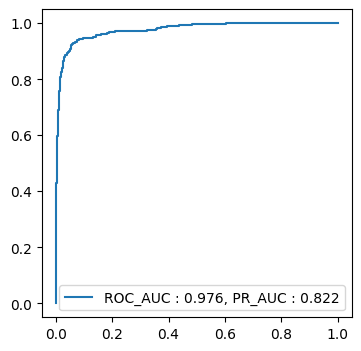

EPOCH: 1
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:50<00:00, 56.48it/s]


Train loss: 0.2057987126697505


100%|██████████| 6571/6571 [01:04<00:00, 101.78it/s]


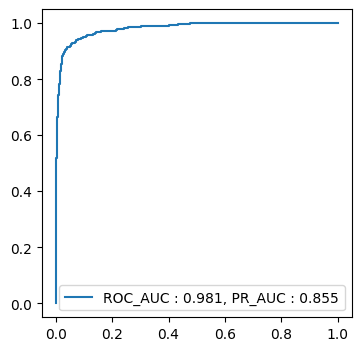

EPOCH: 2
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.87it/s]


Train loss: 0.17846889161517265


100%|██████████| 6571/6571 [01:09<00:00, 94.08it/s] 


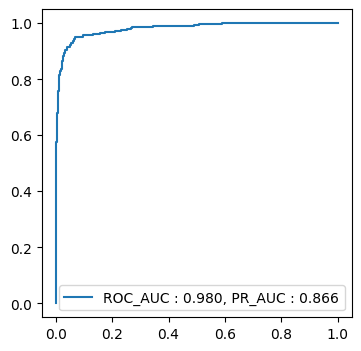

EPOCH: 3
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.54it/s]


Train loss: 0.15558570037018407


100%|██████████| 6571/6571 [01:11<00:00, 92.01it/s] 


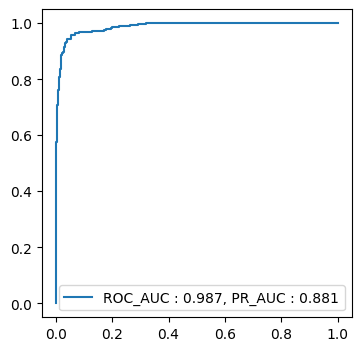

EPOCH: 4
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.39it/s]


Train loss: 0.1489586209531776


100%|██████████| 6571/6571 [01:11<00:00, 91.34it/s] 


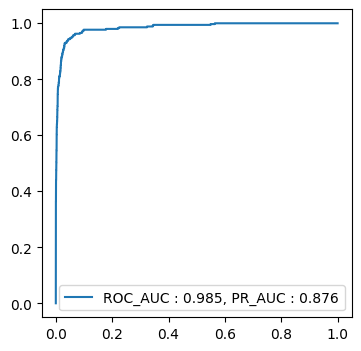

EPOCH: 5
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.59it/s]


Train loss: 0.13351451009863194


100%|██████████| 6571/6571 [01:08<00:00, 95.61it/s] 


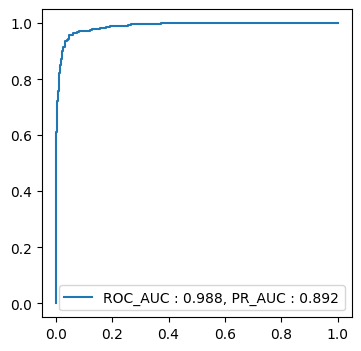

EPOCH: 6
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.15it/s]


Train loss: 0.12440593143289622


100%|██████████| 6571/6571 [01:09<00:00, 94.74it/s] 


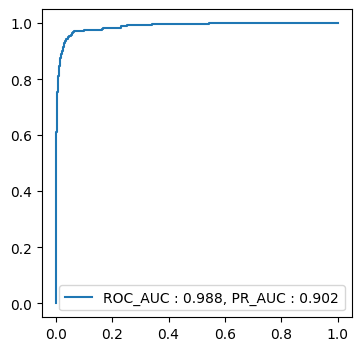

EPOCH: 7
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.19it/s]


Train loss: 0.12449555889383099


100%|██████████| 6571/6571 [01:09<00:00, 95.08it/s] 


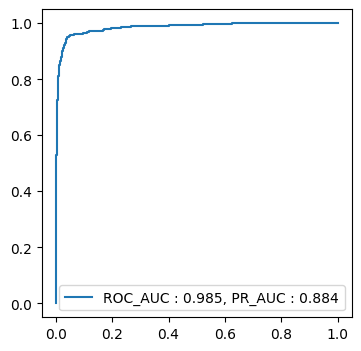

EPOCH: 8
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.94it/s]


Train loss: 0.1143618459204348


100%|██████████| 6571/6571 [01:06<00:00, 98.25it/s] 


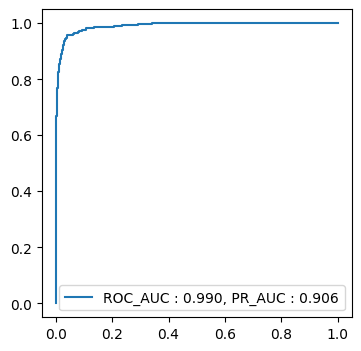

EPOCH: 9
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.79it/s]


Train loss: 0.10897533172490616


100%|██████████| 6571/6571 [01:08<00:00, 96.11it/s] 


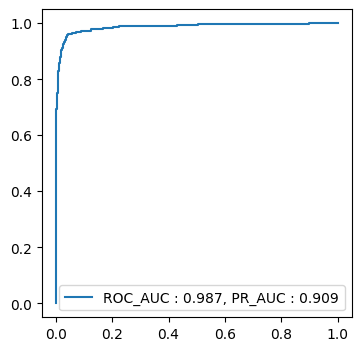

EPOCH: 10
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.10it/s]


Train loss: 0.10976239169531515


100%|██████████| 6571/6571 [01:20<00:00, 82.00it/s] 


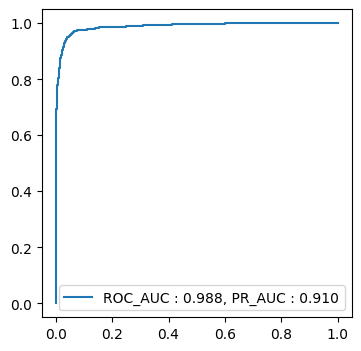

EPOCH: 11
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:57<00:00, 53.39it/s]


Train loss: 0.1100213803437278


100%|██████████| 6571/6571 [01:06<00:00, 99.20it/s] 


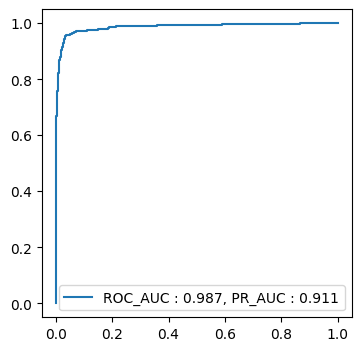

EPOCH: 12
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:58<00:00, 52.88it/s]


Train loss: 0.10879467884466014


100%|██████████| 6571/6571 [01:04<00:00, 101.18it/s]


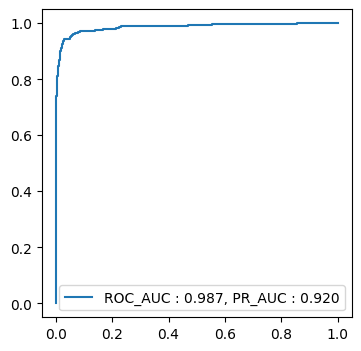

EPOCH: 13
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.04it/s]


Train loss: 0.09356212993540791


100%|██████████| 6571/6571 [01:08<00:00, 96.43it/s] 


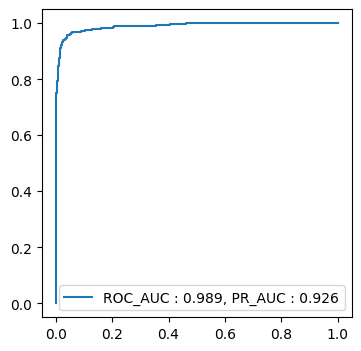

EPOCH: 14
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.76it/s]


Train loss: 0.09207027402519623


100%|██████████| 6571/6571 [01:10<00:00, 93.39it/s] 


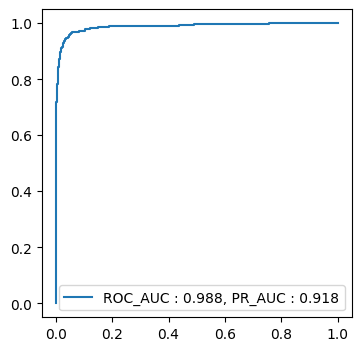

EPOCH: 15
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:57<00:00, 53.35it/s]


Train loss: 0.08709032325787557


100%|██████████| 6571/6571 [01:04<00:00, 102.03it/s]


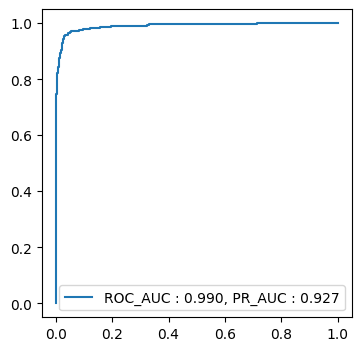

EPOCH: 16
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.09it/s]


Train loss: 0.09015418930543667


100%|██████████| 6571/6571 [01:04<00:00, 102.12it/s]


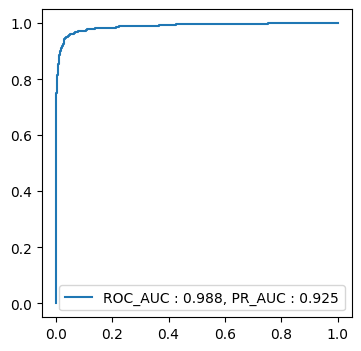

EPOCH: 17
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.36it/s]


Train loss: 0.08084193187523299


100%|██████████| 6571/6571 [01:13<00:00, 88.81it/s] 


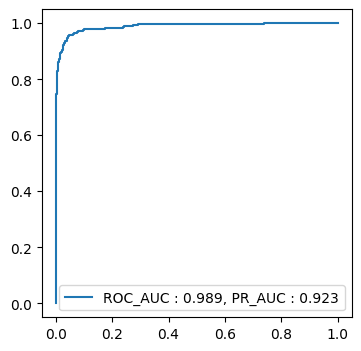

EPOCH: 18
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.55it/s]


Train loss: 0.08397421319213333


100%|██████████| 6571/6571 [01:06<00:00, 99.31it/s] 


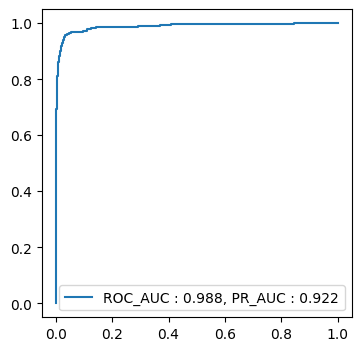

EPOCH: 19
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.40it/s]


Train loss: 0.07222420173931834


100%|██████████| 6571/6571 [01:04<00:00, 101.95it/s]


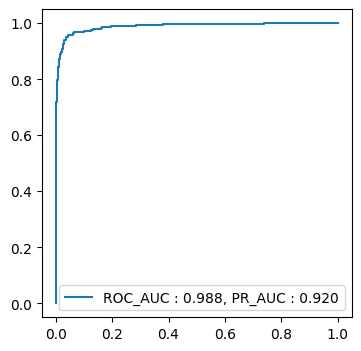

EPOCH: 20
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.76it/s]


Train loss: 0.08005083144935125


100%|██████████| 6571/6571 [01:05<00:00, 100.12it/s]


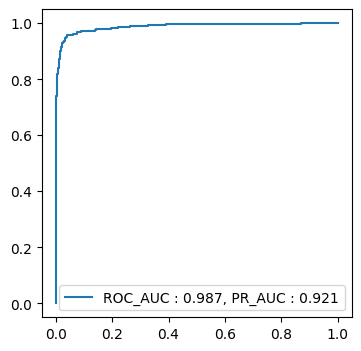

EPOCH: 21
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.65it/s]


Train loss: 0.07024040929353625


100%|██████████| 6571/6571 [01:04<00:00, 102.08it/s]


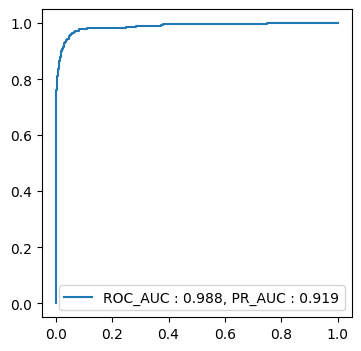

EPOCH: 22
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.36it/s]


Train loss: 0.0882650811892542


100%|██████████| 6571/6571 [01:08<00:00, 96.58it/s] 


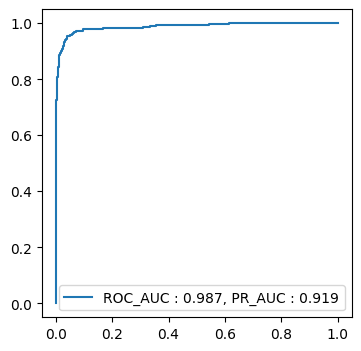

EPOCH: 23
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.10it/s]


Train loss: 0.07134416335980685


100%|██████████| 6571/6571 [01:06<00:00, 98.80it/s] 


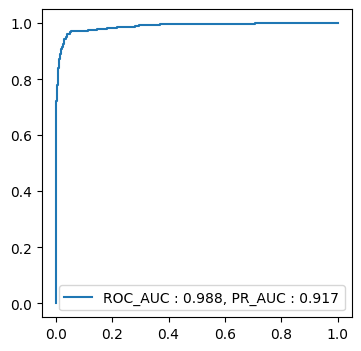

EPOCH: 24
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.01it/s]


Train loss: 0.07007845706429479


100%|██████████| 6571/6571 [01:07<00:00, 97.64it/s] 


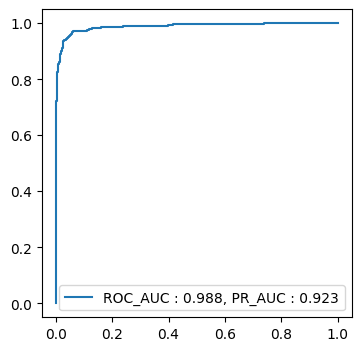

EPOCH: 25
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.64it/s]


Train loss: 0.07267114796718993


100%|██████████| 6571/6571 [01:07<00:00, 96.68it/s] 


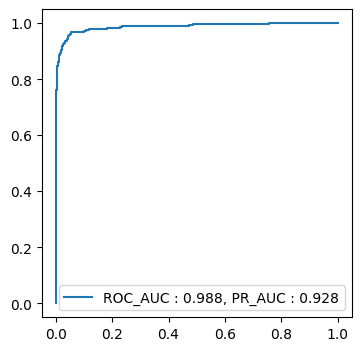

EPOCH: 26
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:58<00:00, 52.83it/s]


Train loss: 0.07865702081025898


100%|██████████| 6571/6571 [01:06<00:00, 99.20it/s] 


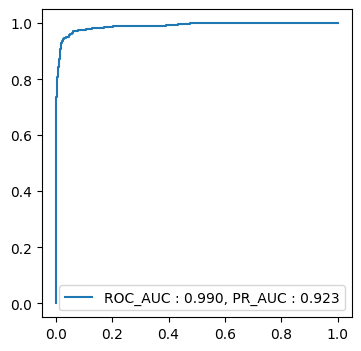

EPOCH: 27
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:57<00:00, 53.22it/s]


Train loss: 0.0643817972439776


100%|██████████| 6571/6571 [01:06<00:00, 98.30it/s] 


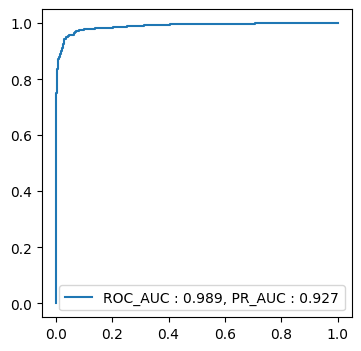

EPOCH: 28
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:58<00:00, 53.03it/s]


Train loss: 0.06227393810720565


100%|██████████| 6571/6571 [01:08<00:00, 96.38it/s] 


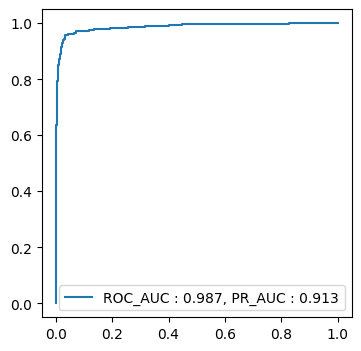

EPOCH: 29
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.08it/s]


Train loss: 0.06605212590456284


100%|██████████| 6571/6571 [01:05<00:00, 100.60it/s]


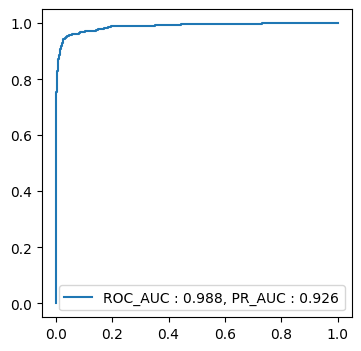

EPOCH: 30
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.37it/s]


Train loss: 0.0630591928235729


100%|██████████| 6571/6571 [01:08<00:00, 96.19it/s] 


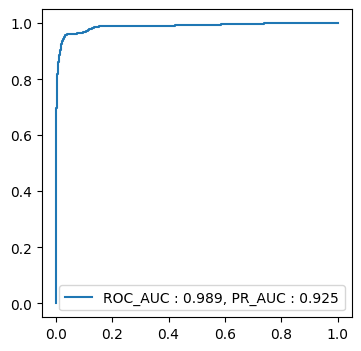

EPOCH: 31
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.61it/s]


Train loss: 0.06516416752201916


100%|██████████| 6571/6571 [01:05<00:00, 100.74it/s]


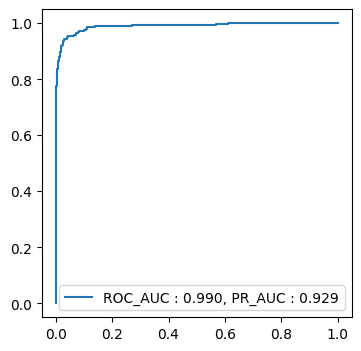

EPOCH: 32
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.66it/s]


Train loss: 0.06211833450896535


100%|██████████| 6571/6571 [01:06<00:00, 99.04it/s] 


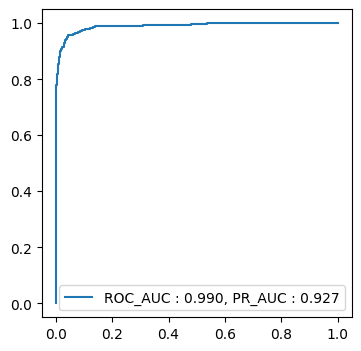

EPOCH: 33
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.95it/s]


Train loss: 0.061754189232391406


100%|██████████| 6571/6571 [01:06<00:00, 98.31it/s] 


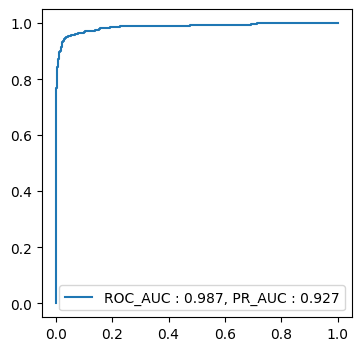

EPOCH: 34
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.20it/s]


Train loss: 0.05740596911895227


100%|██████████| 6571/6571 [01:09<00:00, 94.02it/s] 


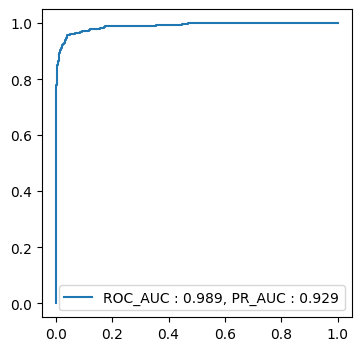

EPOCH: 35
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.72it/s]


Train loss: 0.061229833284158194


100%|██████████| 6571/6571 [01:14<00:00, 88.16it/s] 


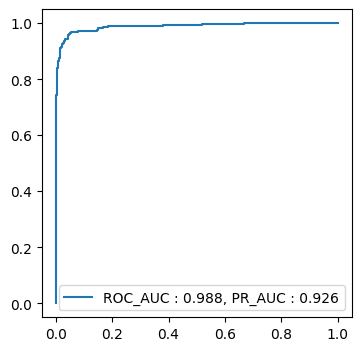

EPOCH: 36
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.55it/s]


Train loss: 0.060156291675614315


100%|██████████| 6571/6571 [01:07<00:00, 97.11it/s] 


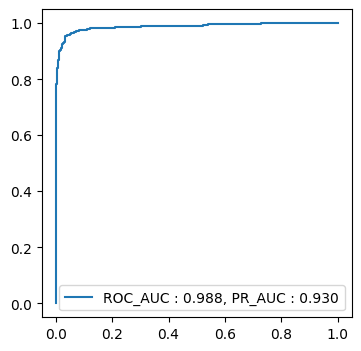

EPOCH: 37
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.75it/s]


Train loss: 0.062238022464943574


100%|██████████| 6571/6571 [01:05<00:00, 100.03it/s]


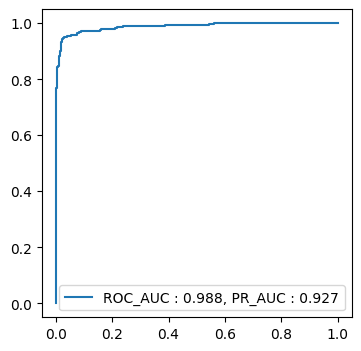

EPOCH: 38
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.44it/s]


Train loss: 0.055771284823080636


100%|██████████| 6571/6571 [01:04<00:00, 102.58it/s]


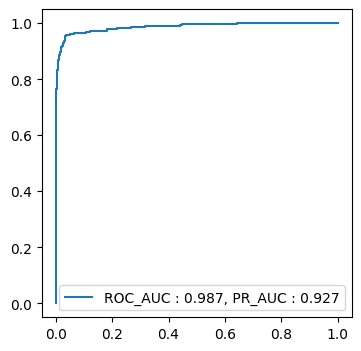

EPOCH: 39
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.76it/s]


Train loss: 0.0551743014238011


100%|██████████| 6571/6571 [01:05<00:00, 100.71it/s]


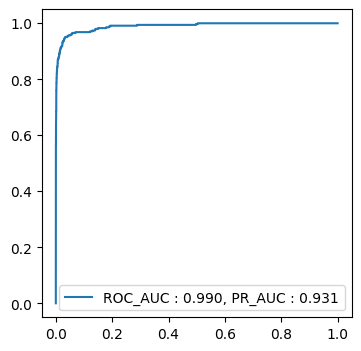

EPOCH: 40
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.21it/s]


Train loss: 0.05729280787351968


100%|██████████| 6571/6571 [01:08<00:00, 96.15it/s] 


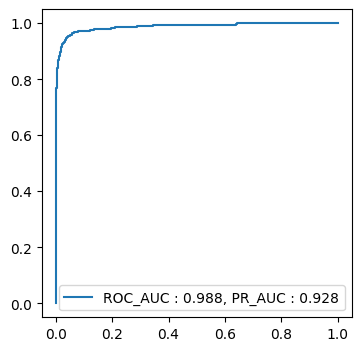

EPOCH: 41
Train dataloader len: 6260


100%|██████████| 6260/6260 [02:01<00:00, 51.51it/s]


Train loss: 0.06184979383626395


100%|██████████| 6571/6571 [01:10<00:00, 92.87it/s] 


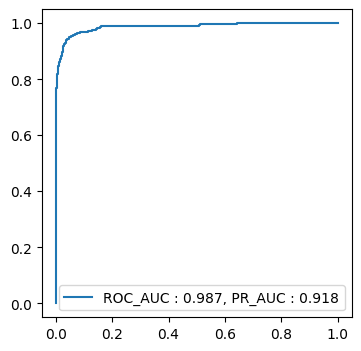

EPOCH: 42
Train dataloader len: 6260


100%|██████████| 6260/6260 [02:01<00:00, 51.47it/s]


Train loss: 0.05883506391634005


100%|██████████| 6571/6571 [01:13<00:00, 89.41it/s] 


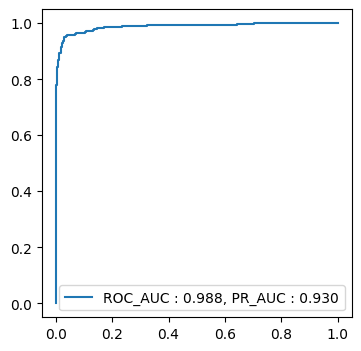

EPOCH: 43
Train dataloader len: 6260


100%|██████████| 6260/6260 [02:02<00:00, 51.23it/s]


Train loss: 0.05309630232584958


100%|██████████| 6571/6571 [01:09<00:00, 95.10it/s] 


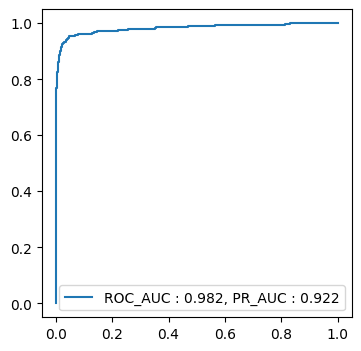

EPOCH: 44
Train dataloader len: 6260


100%|██████████| 6260/6260 [02:00<00:00, 51.94it/s]


Train loss: 0.0567833235453719


100%|██████████| 6571/6571 [01:12<00:00, 90.55it/s] 


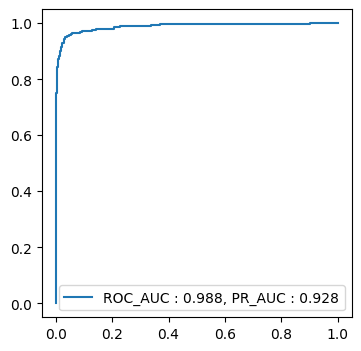

EPOCH: 45
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.92it/s]


Train loss: 0.05389219665984297


100%|██████████| 6571/6571 [01:06<00:00, 98.41it/s] 


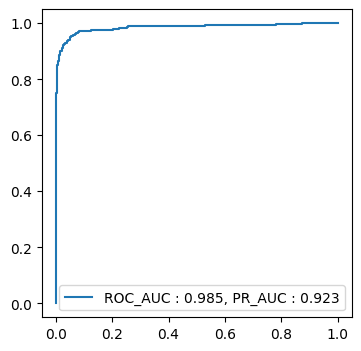

EPOCH: 46
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.21it/s]


Train loss: 0.04945297671134139


100%|██████████| 6571/6571 [01:07<00:00, 97.81it/s] 


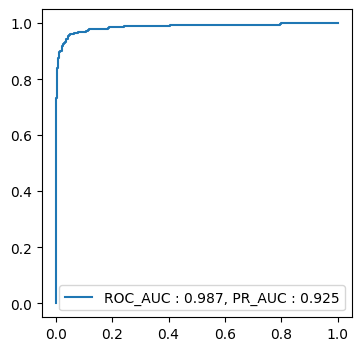

EPOCH: 47
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.74it/s]


Train loss: 0.058426488155869684


100%|██████████| 6571/6571 [01:08<00:00, 95.86it/s] 


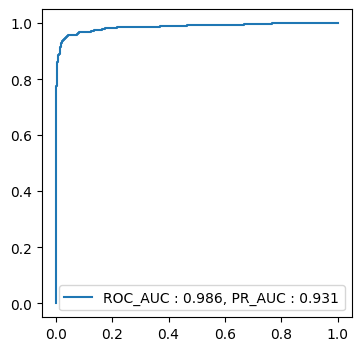

EPOCH: 48
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.13it/s]


Train loss: 0.05093057475344352


100%|██████████| 6571/6571 [01:08<00:00, 95.65it/s] 


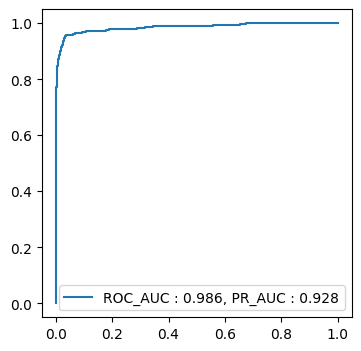

EPOCH: 49
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.81it/s]


Train loss: 0.051233705644281674


100%|██████████| 6571/6571 [01:07<00:00, 97.56it/s] 


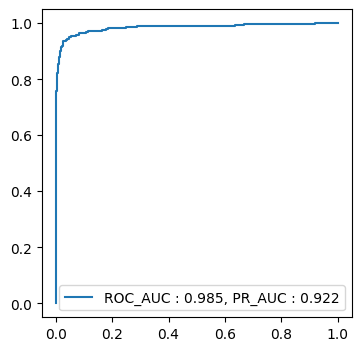

EPOCH: 50
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.37it/s]


Train loss: 0.04831106701304604


100%|██████████| 6571/6571 [01:09<00:00, 95.09it/s] 


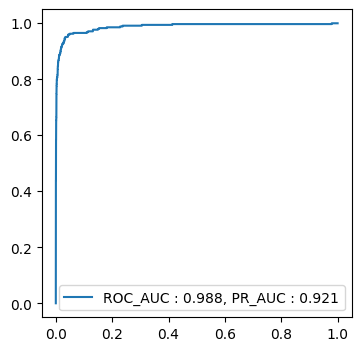

EPOCH: 51
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.85it/s]


Train loss: 0.051754696255432026


100%|██████████| 6571/6571 [01:08<00:00, 96.33it/s] 


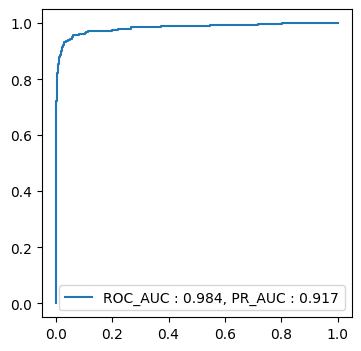

EPOCH: 52
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.28it/s]


Train loss: 0.04623103061212968


100%|██████████| 6571/6571 [01:05<00:00, 100.13it/s]


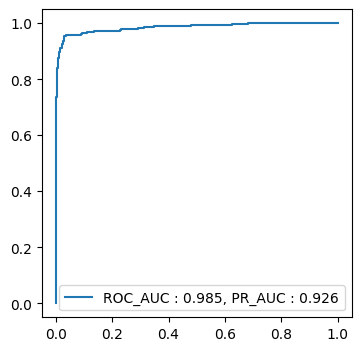

EPOCH: 53
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.45it/s]


Train loss: 0.04975810379960498


100%|██████████| 6571/6571 [01:07<00:00, 97.71it/s] 


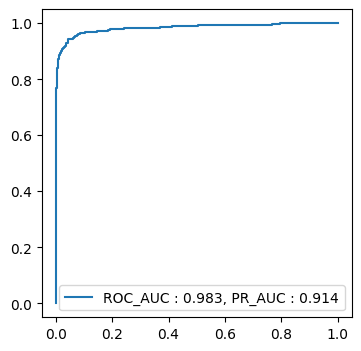

EPOCH: 54
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.40it/s]


Train loss: 0.050990535291981824


100%|██████████| 6571/6571 [01:06<00:00, 99.40it/s] 


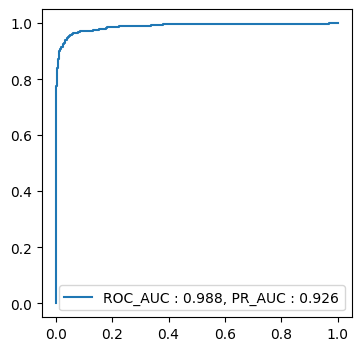

EPOCH: 55
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.26it/s]


Train loss: 0.04953914019167424


100%|██████████| 6571/6571 [01:08<00:00, 96.32it/s] 


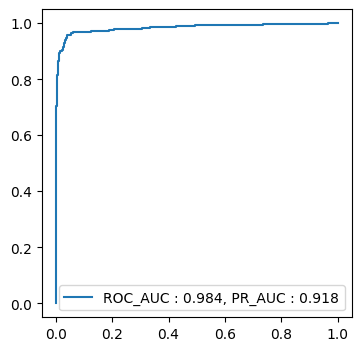

EPOCH: 56
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.63it/s]


Train loss: 0.0469883045066052


100%|██████████| 6571/6571 [01:05<00:00, 101.06it/s]


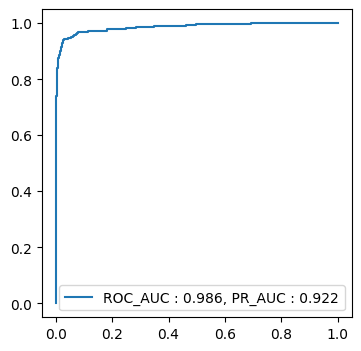

EPOCH: 57
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.49it/s]


Train loss: 0.04733720555719894


100%|██████████| 6571/6571 [01:07<00:00, 98.04it/s] 


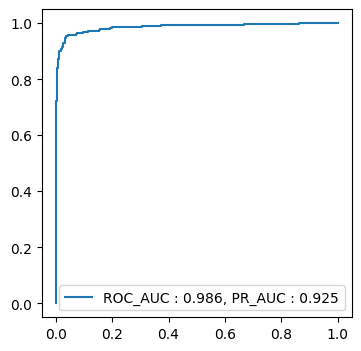

EPOCH: 58
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.71it/s]


Train loss: 0.0454521189749091


100%|██████████| 6571/6571 [01:06<00:00, 98.49it/s] 


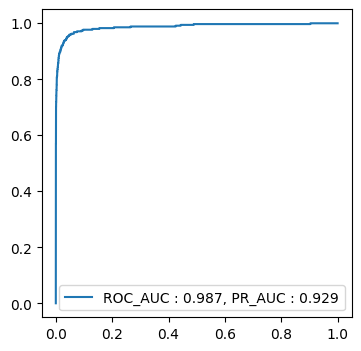

EPOCH: 59
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.24it/s]


Train loss: 0.04461064900351491


100%|██████████| 6571/6571 [01:08<00:00, 96.45it/s] 


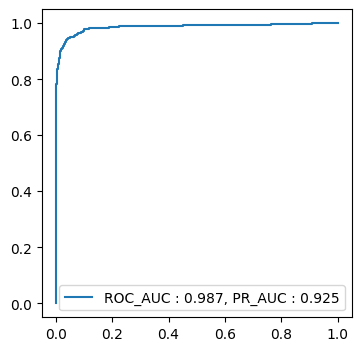

EPOCH: 60
Train dataloader len: 6260


100%|██████████| 6571/6571 [01:13<00:00, 89.57it/s] 


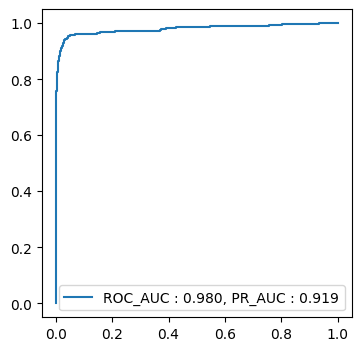

EPOCH: 80
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.52it/s]


Train loss: 0.039642181638241035


100%|██████████| 6571/6571 [01:05<00:00, 99.66it/s] 


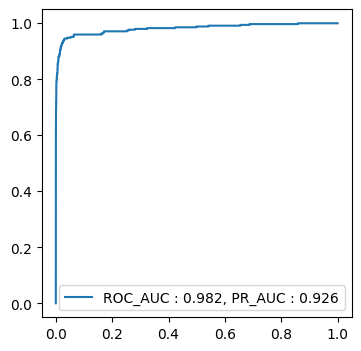

EPOCH: 81
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.88it/s]


Train loss: 0.04374878703676398


100%|██████████| 6571/6571 [01:05<00:00, 100.21it/s]


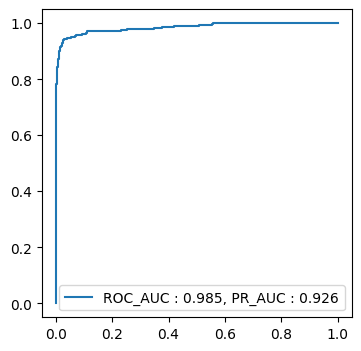

EPOCH: 82
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.89it/s]


Train loss: 0.03701804993246452


100%|██████████| 6571/6571 [01:05<00:00, 99.72it/s] 


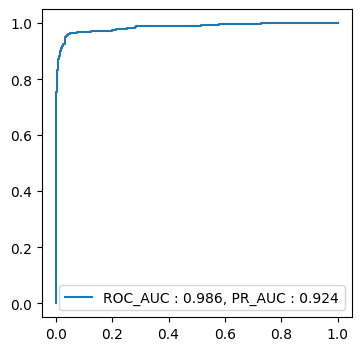

EPOCH: 83
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.84it/s]


Train loss: 0.0354530276960884


100%|██████████| 6571/6571 [01:06<00:00, 99.05it/s] 


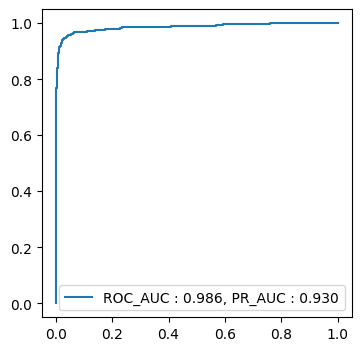

EPOCH: 84
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.85it/s]


Train loss: 0.035630555648501684


100%|██████████| 6571/6571 [01:05<00:00, 99.95it/s] 


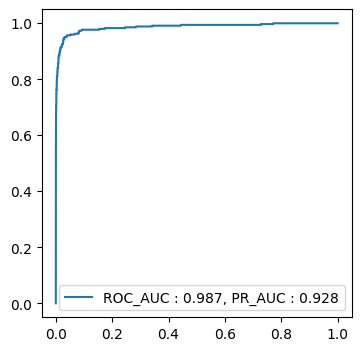

EPOCH: 85
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.55it/s]


Train loss: 0.04147759455090304


100%|██████████| 6571/6571 [01:06<00:00, 99.45it/s] 


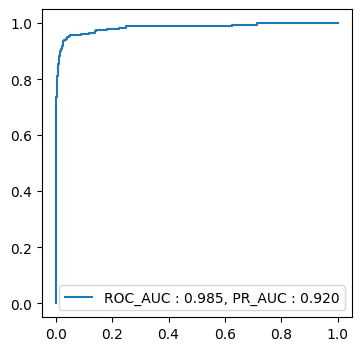

EPOCH: 86
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.87it/s]


Train loss: 0.03554755604596253


100%|██████████| 6571/6571 [01:05<00:00, 100.80it/s]


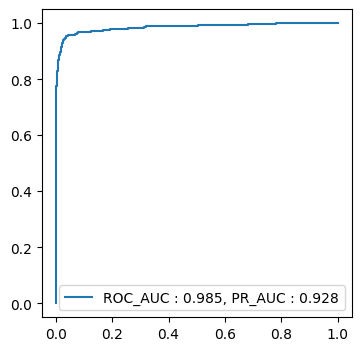

EPOCH: 87
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.91it/s]


Train loss: 0.03571185082918563


100%|██████████| 6571/6571 [01:05<00:00, 100.52it/s]


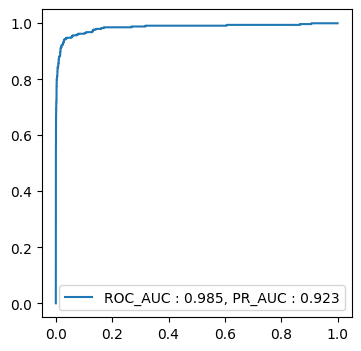

EPOCH: 88
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.06it/s]


Train loss: 0.034859068881882095


100%|██████████| 6571/6571 [01:06<00:00, 98.66it/s] 


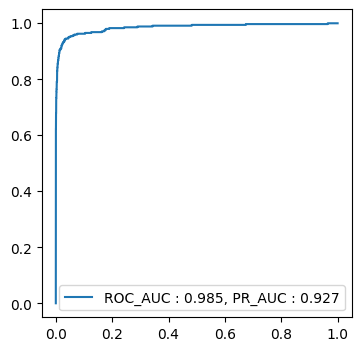

EPOCH: 89
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 53.99it/s]


Train loss: 0.037587394059721925


100%|██████████| 6571/6571 [01:05<00:00, 99.56it/s] 


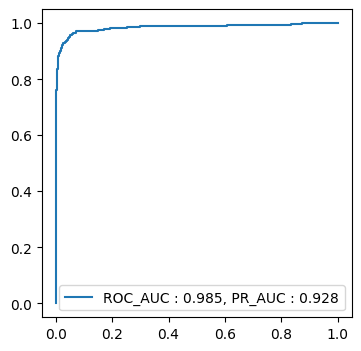

EPOCH: 90
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.59it/s]


Train loss: 0.03531391972298051


100%|██████████| 6571/6571 [01:05<00:00, 100.54it/s]


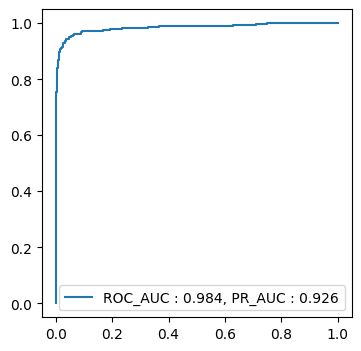

EPOCH: 91
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.01it/s]


Train loss: 0.04435194173384499


100%|██████████| 6571/6571 [01:07<00:00, 97.07it/s] 


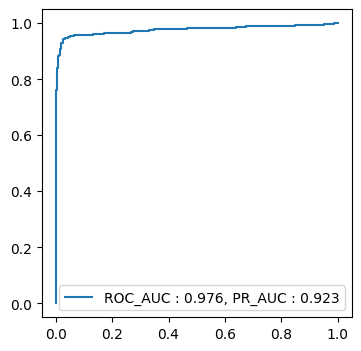

EPOCH: 92
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.63it/s]


Train loss: 0.04056981700437055


100%|██████████| 6571/6571 [01:09<00:00, 95.01it/s] 


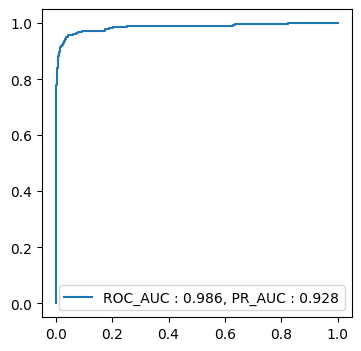

EPOCH: 93
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.83it/s]


Train loss: 0.029497589380096396


100%|██████████| 6571/6571 [01:06<00:00, 99.06it/s] 


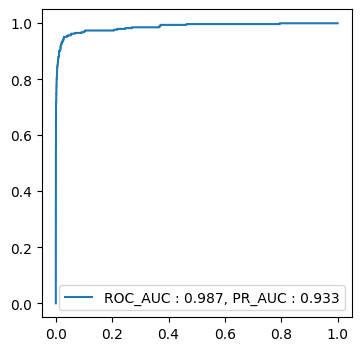

EPOCH: 94
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.48it/s]


Train loss: 0.03820910859675783


100%|██████████| 6571/6571 [01:08<00:00, 95.41it/s] 


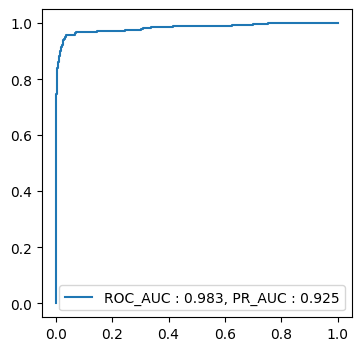

EPOCH: 95
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.60it/s]


Train loss: 0.03775447613260272


100%|██████████| 6571/6571 [01:08<00:00, 96.29it/s] 


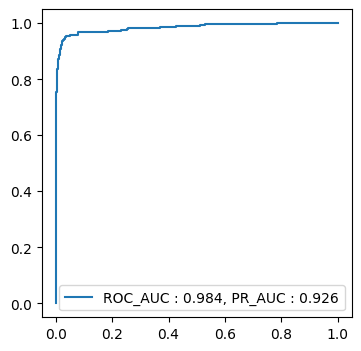

EPOCH: 96
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.76it/s]


Train loss: 0.03088819380637968


100%|██████████| 6571/6571 [01:07<00:00, 97.36it/s] 


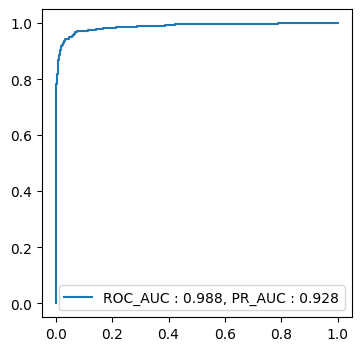

EPOCH: 97
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.84it/s]


Train loss: 0.034317621386556176


100%|██████████| 6571/6571 [01:08<00:00, 95.81it/s] 


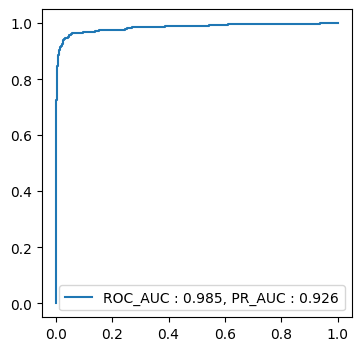

EPOCH: 98
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.35it/s]


Train loss: 0.0437148004425508


100%|██████████| 6571/6571 [01:07<00:00, 96.69it/s] 


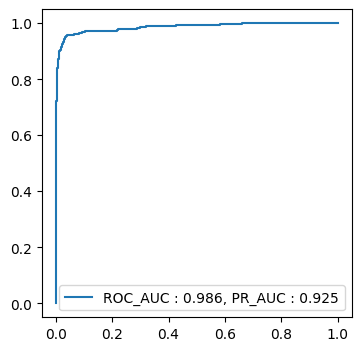

EPOCH: 99
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.13it/s]


Train loss: 0.030904082759711227


100%|██████████| 6571/6571 [01:09<00:00, 94.16it/s] 


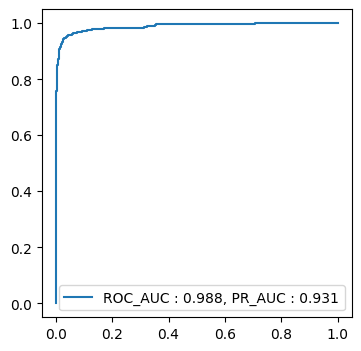

EPOCH: 100
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.03it/s]


Train loss: 0.03373132067215676


100%|██████████| 6571/6571 [01:08<00:00, 95.86it/s] 


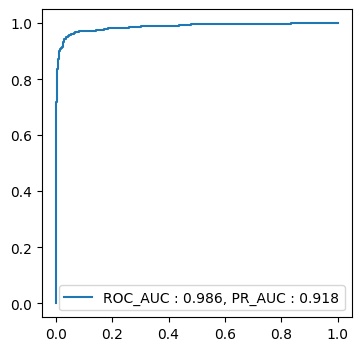

EPOCH: 101
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.31it/s]


Train loss: 0.04014480196003114


100%|██████████| 6571/6571 [01:09<00:00, 94.12it/s] 


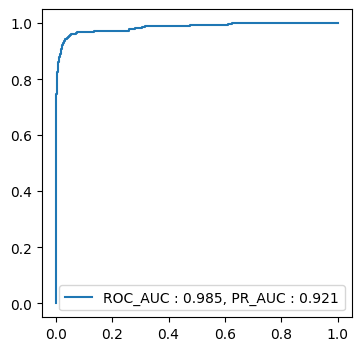

EPOCH: 102
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.19it/s]


Train loss: 0.03813163828774135


100%|██████████| 6571/6571 [01:09<00:00, 94.89it/s] 


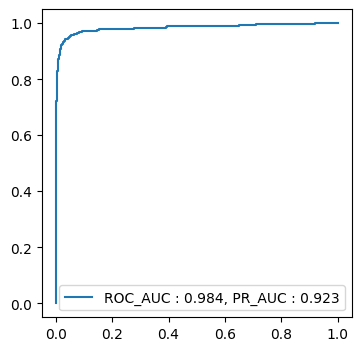

EPOCH: 103
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.43it/s]


Train loss: 0.03582354297932438


100%|██████████| 6571/6571 [01:10<00:00, 92.58it/s] 


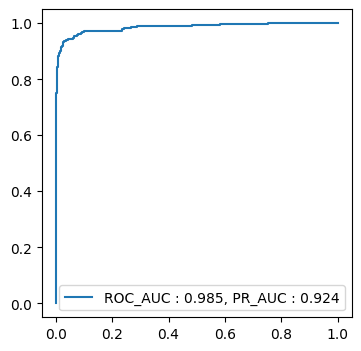

EPOCH: 104
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.62it/s]


Train loss: 0.0290734794628017


100%|██████████| 6571/6571 [01:11<00:00, 91.88it/s] 


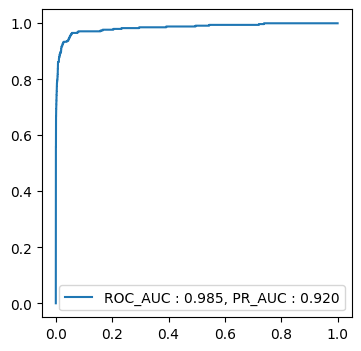

EPOCH: 105
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.65it/s]


Train loss: 0.041705708519434795


100%|██████████| 6571/6571 [01:08<00:00, 95.86it/s] 


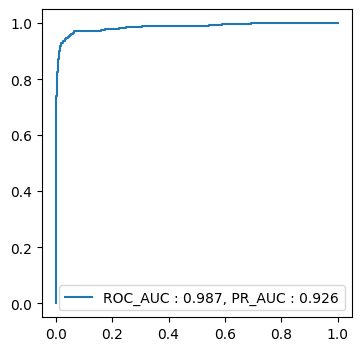

EPOCH: 106
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.34it/s]


Train loss: 0.03386691393737917


100%|██████████| 6571/6571 [01:09<00:00, 94.87it/s] 


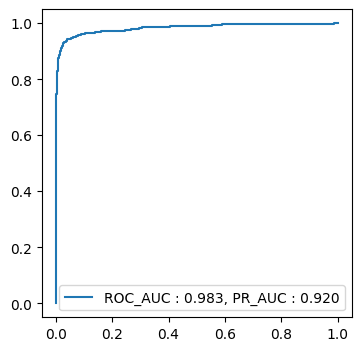

EPOCH: 107
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.70it/s]


Train loss: 0.026067476751636752


100%|██████████| 6571/6571 [01:11<00:00, 92.41it/s] 


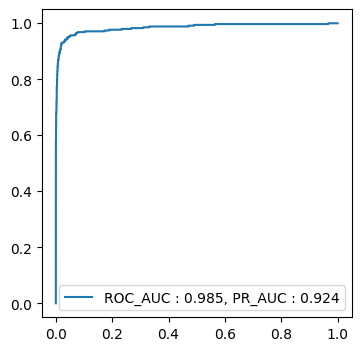

EPOCH: 108
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.68it/s]


Train loss: 0.03411955224259511


100%|██████████| 6571/6571 [01:12<00:00, 91.17it/s] 


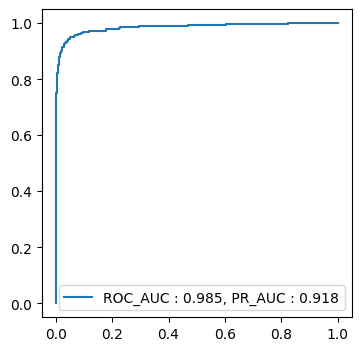

EPOCH: 109
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.88it/s]


Train loss: 0.0362716338658479


100%|██████████| 6571/6571 [01:12<00:00, 90.24it/s] 


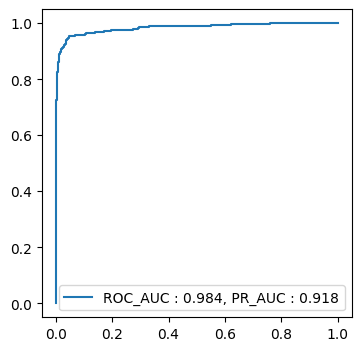

EPOCH: 110
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:50<00:00, 56.54it/s]


Train loss: 0.030350200589357244


100%|██████████| 6571/6571 [01:11<00:00, 92.02it/s] 


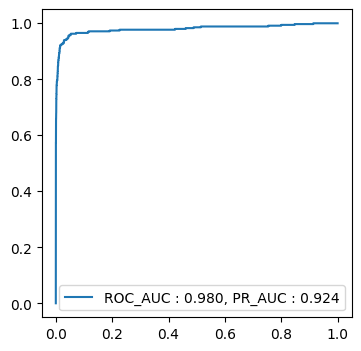

EPOCH: 111
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.80it/s]


Train loss: 0.03102804885555285


100%|██████████| 6571/6571 [01:10<00:00, 92.63it/s] 


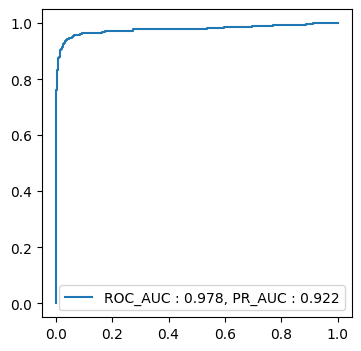

EPOCH: 112
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 54.99it/s]


Train loss: 0.036220259237658974


100%|██████████| 6571/6571 [01:13<00:00, 89.99it/s] 


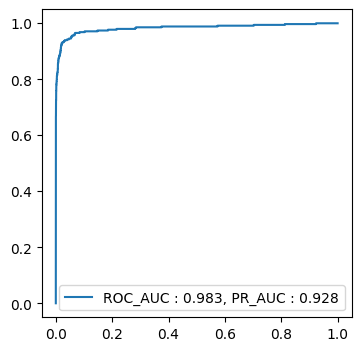

EPOCH: 113
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:57<00:00, 53.35it/s]


Train loss: 0.035224749814317065


100%|██████████| 6260/6260 [01:59<00:00, 52.33it/s] 


Train loss: 0.03038821650886937


100%|██████████| 6571/6571 [01:13<00:00, 89.10it/s] 


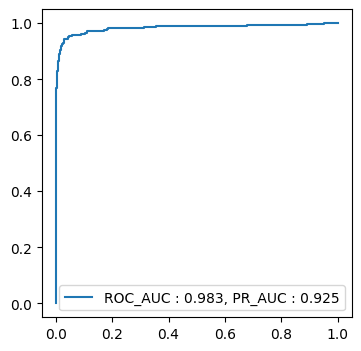

EPOCH: 127
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:57<00:00, 53.06it/s]


Train loss: 0.03630749641368775


100%|██████████| 6571/6571 [01:17<00:00, 84.45it/s] 


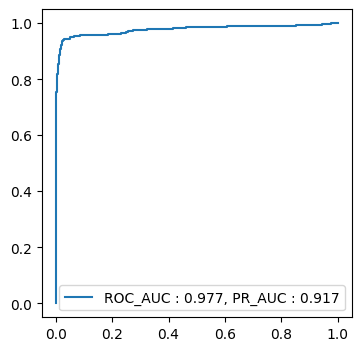

EPOCH: 128
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:58<00:00, 53.02it/s]


Train loss: 0.03050719877397032


100%|██████████| 6260/6260 [01:52<00:00, 55.80it/s]]


Train loss: 0.030271660494034503


100%|██████████| 6571/6571 [01:10<00:00, 93.82it/s] 


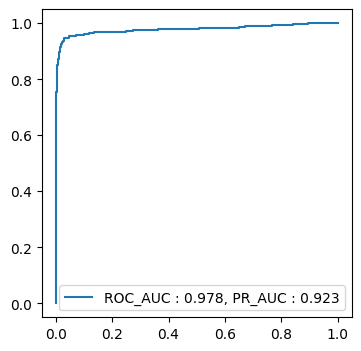

EPOCH: 132
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:53<00:00, 55.22it/s]


Train loss: 0.029632574598008967


100%|██████████| 6571/6571 [01:08<00:00, 95.73it/s] 


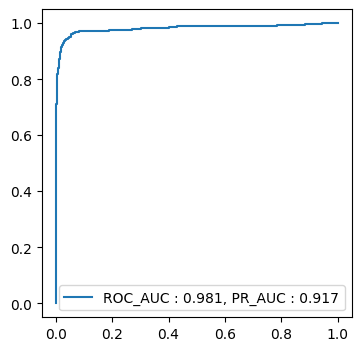

EPOCH: 133
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.54it/s]


Train loss: 0.032168781278926056


100%|██████████| 6260/6260 [01:53<00:00, 55.30it/s] 


Train loss: 0.036355726321263146


100%|██████████| 6260/6260 [01:59<00:00, 52.19it/s]


Train loss: 0.029151508802547823


100%|██████████| 6571/6571 [01:07<00:00, 97.02it/s] 


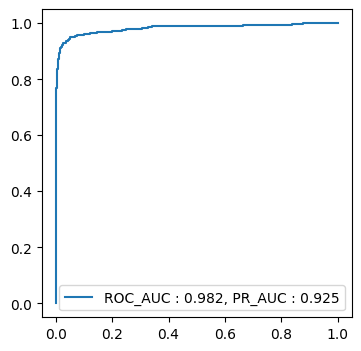

EPOCH: 140
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.27it/s]


Train loss: 0.0249469293775527


100%|██████████| 6571/6571 [01:07<00:00, 97.85it/s] 


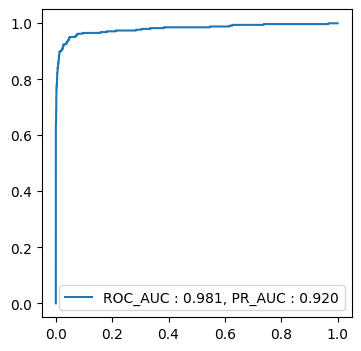

EPOCH: 141
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.70it/s]


Train loss: 0.03426990482513892


100%|██████████| 6571/6571 [01:04<00:00, 101.47it/s]


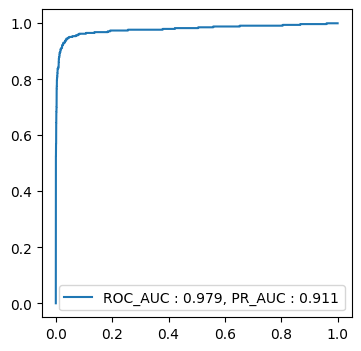

EPOCH: 142
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.96it/s]


Train loss: 0.026912933372382937


100%|██████████| 6571/6571 [01:07<00:00, 97.56it/s] 


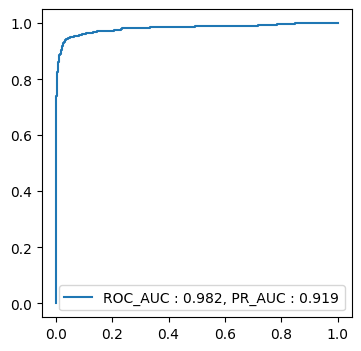

EPOCH: 143
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.01it/s]


Train loss: 0.0284560579854037


100%|██████████| 6571/6571 [01:06<00:00, 98.13it/s] 


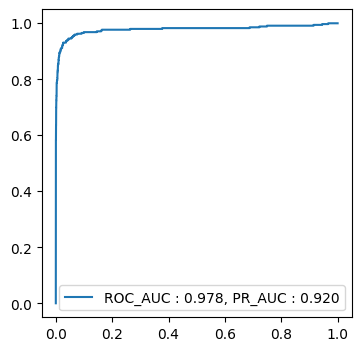

EPOCH: 144
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.32it/s]


Train loss: 0.02406527011599272


100%|██████████| 6571/6571 [01:06<00:00, 98.87it/s] 


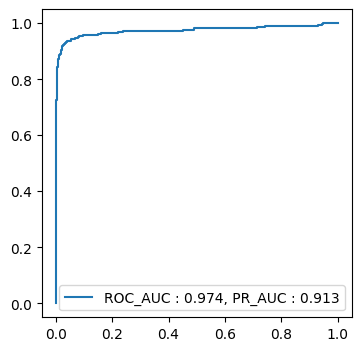

EPOCH: 145
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.58it/s]


Train loss: 0.03316965418957413


100%|██████████| 6571/6571 [01:05<00:00, 100.30it/s]


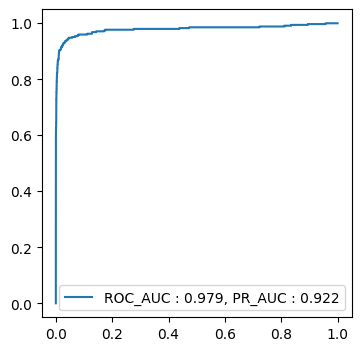

EPOCH: 146
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.40it/s]


Train loss: 0.029087494360096264


100%|██████████| 6571/6571 [01:12<00:00, 90.03it/s] 


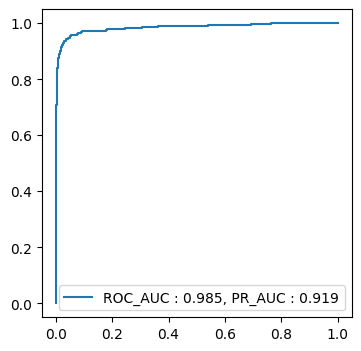

EPOCH: 147
Train dataloader len: 6260


100%|██████████| 6260/6260 [02:00<00:00, 52.05it/s]


Train loss: 0.0341917878012082


100%|██████████| 6571/6571 [01:07<00:00, 97.42it/s] 


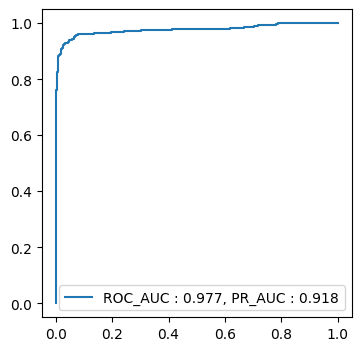

EPOCH: 148
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 53.97it/s]


Train loss: 0.026598616925292008


100%|██████████| 6571/6571 [01:05<00:00, 100.74it/s]


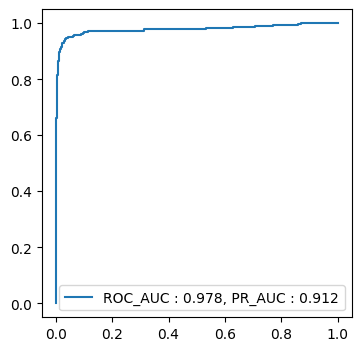

EPOCH: 149
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.60it/s]


Train loss: 0.02555749878301933


100%|██████████| 6571/6571 [01:10<00:00, 93.33it/s] 


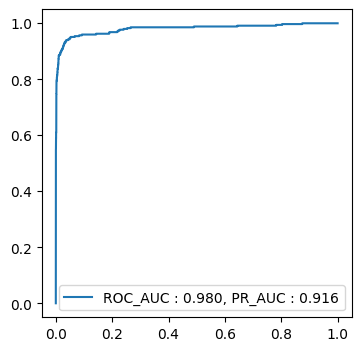

EPOCH: 150
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:56<00:00, 53.54it/s]


Train loss: 0.028514213059151788


100%|██████████| 6571/6571 [01:05<00:00, 100.04it/s]


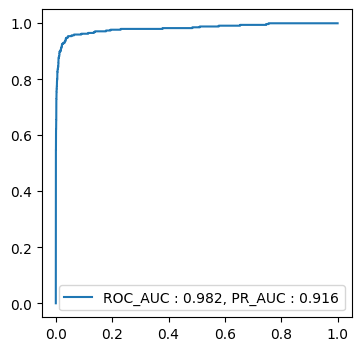

EPOCH: 151
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:58<00:00, 53.04it/s]


Train loss: 0.030299489908003113


100%|██████████| 6571/6571 [01:05<00:00, 100.46it/s]


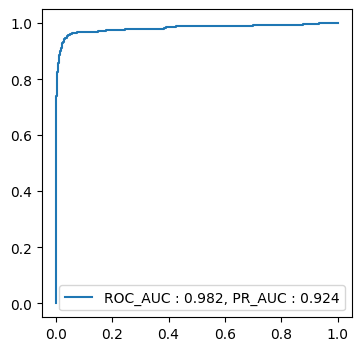

EPOCH: 152
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.28it/s]


Train loss: 0.02542382114024149


100%|██████████| 6571/6571 [01:04<00:00, 101.48it/s]


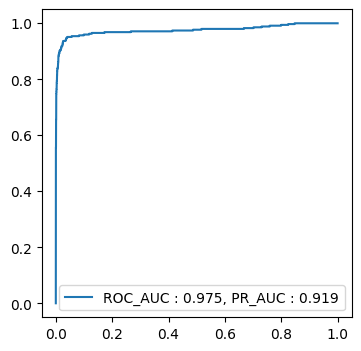

EPOCH: 153
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.85it/s]


Train loss: 0.023930296917793664


100%|██████████| 6571/6571 [01:06<00:00, 98.92it/s] 


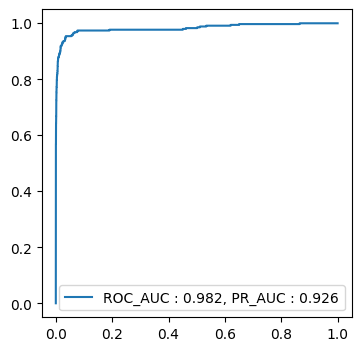

EPOCH: 154
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.52it/s]


Train loss: 0.0195544536632745


100%|██████████| 6571/6571 [01:05<00:00, 100.00it/s]


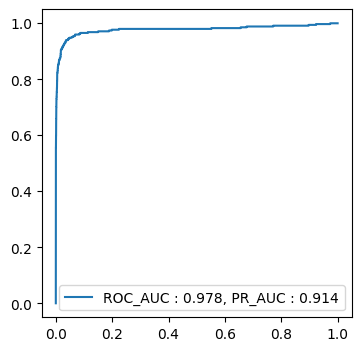

EPOCH: 160
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:55<00:00, 54.26it/s]


Train loss: 0.02791582075003545


100%|██████████| 6571/6571 [01:04<00:00, 101.38it/s]


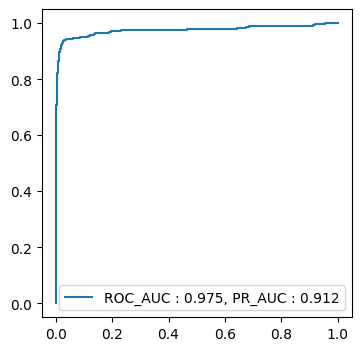

EPOCH: 161
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:54<00:00, 54.91it/s]


Train loss: 0.024714583618911844


100%|██████████| 6571/6571 [01:06<00:00, 99.29it/s] 


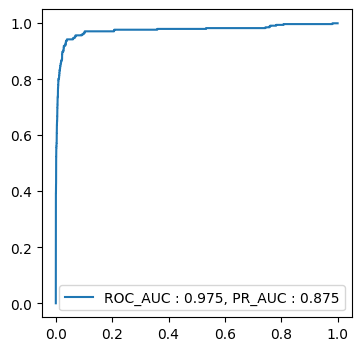

EPOCH: 162
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.48it/s]


Train loss: 0.0251932726499166


100%|██████████| 6260/6260 [01:52<00:00, 55.62it/s] 


Train loss: 0.026661892533936807


100%|██████████| 6260/6260 [01:53<00:00, 55.33it/s]]


Train loss: 0.029878216089030227


100%|██████████| 6571/6571 [01:08<00:00, 95.36it/s] 


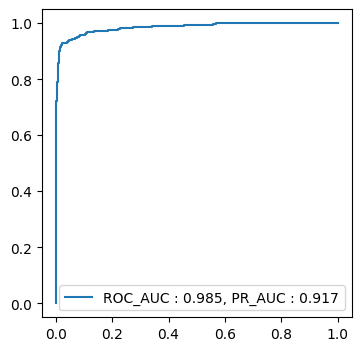

EPOCH: 170
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.54it/s]


Train loss: 0.02548651913124812


100%|██████████| 6571/6571 [01:11<00:00, 91.77it/s] 


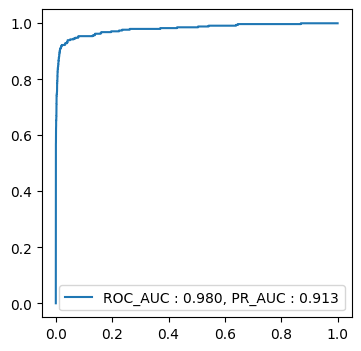

EPOCH: 171
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.47it/s]


Train loss: 0.026712823953040993


100%|██████████| 6571/6571 [01:09<00:00, 93.93it/s] 


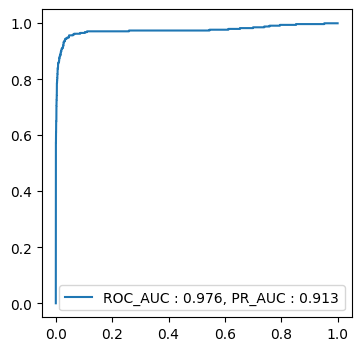

EPOCH: 175
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.79it/s]


Train loss: 0.02559387492397803


100%|██████████| 6571/6571 [01:11<00:00, 91.79it/s] 


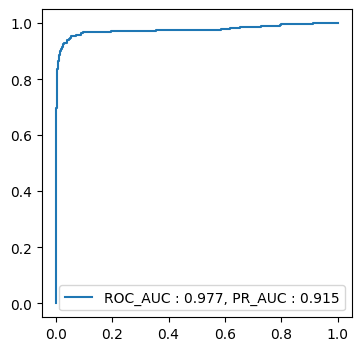

EPOCH: 176
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.84it/s]


Train loss: 0.02311316978258048


100%|██████████| 6571/6571 [01:10<00:00, 93.61it/s] 


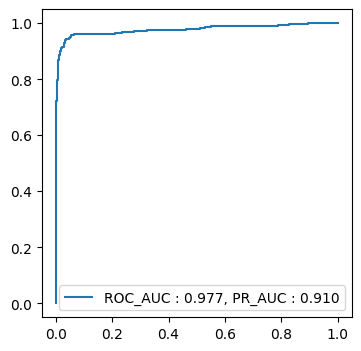

EPOCH: 177
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.88it/s]


Train loss: 0.02346296468168907


100%|██████████| 6571/6571 [01:10<00:00, 93.55it/s] 


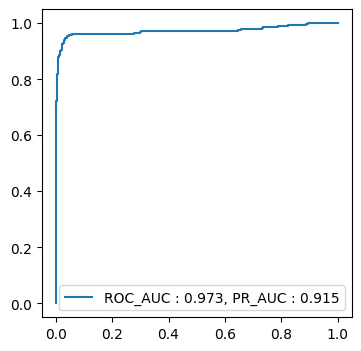

EPOCH: 178
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.01it/s]


Train loss: 0.02772007701118876


100%|██████████| 6571/6571 [01:09<00:00, 94.73it/s] 


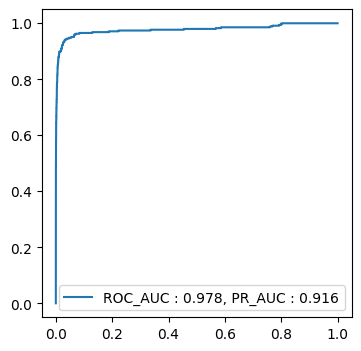

EPOCH: 179
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.10it/s]


Train loss: 0.026823321879927167


100%|██████████| 6571/6571 [01:11<00:00, 92.46it/s] 


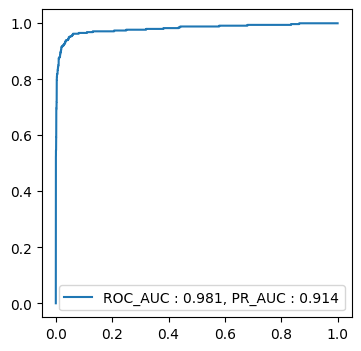

EPOCH: 180
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.21it/s]


Train loss: 0.025242532683515


100%|██████████| 6571/6571 [01:13<00:00, 89.09it/s] 


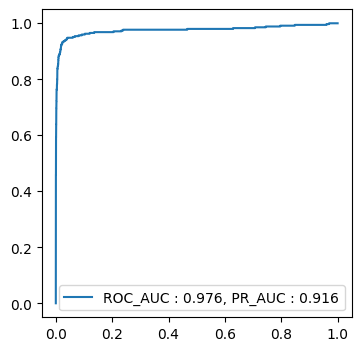

EPOCH: 181
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 55.97it/s]


Train loss: 0.022332444600220124


100%|██████████| 6571/6571 [01:12<00:00, 90.84it/s] 


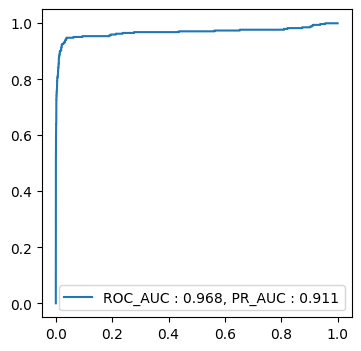

EPOCH: 182
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 55.93it/s]


Train loss: 0.024675008835079677


100%|██████████| 6571/6571 [01:13<00:00, 89.57it/s] 


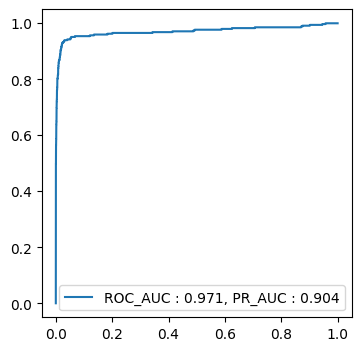

EPOCH: 183
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:50<00:00, 56.43it/s]


Train loss: 0.022405060624204023


100%|██████████| 6571/6571 [01:12<00:00, 90.03it/s] 


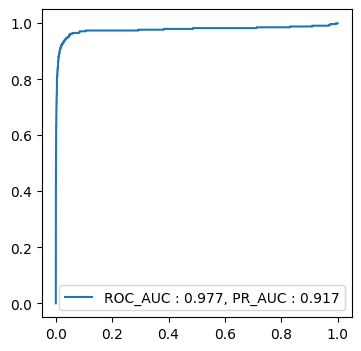

EPOCH: 184
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.01it/s]


Train loss: 0.022782080965168223


100%|██████████| 6571/6571 [01:13<00:00, 88.90it/s] 


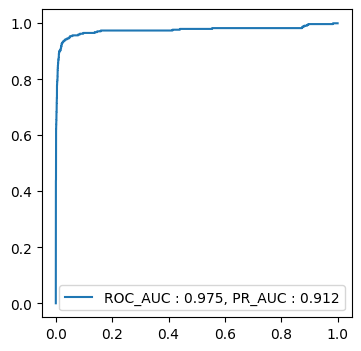

EPOCH: 185
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.86it/s]


Train loss: 0.031041613109769755


100%|██████████| 6571/6571 [01:09<00:00, 94.75it/s] 


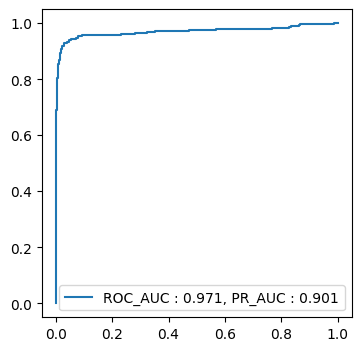

EPOCH: 186
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 55.91it/s]


Train loss: 0.026318760619441262


100%|██████████| 6571/6571 [01:11<00:00, 91.37it/s] 


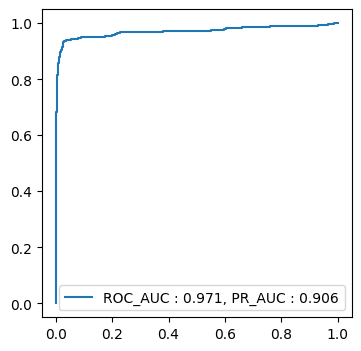

EPOCH: 187
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.31it/s]


Train loss: 0.023909970455519212


100%|██████████| 6571/6571 [01:11<00:00, 91.74it/s] 


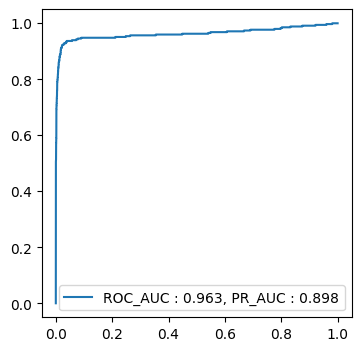

EPOCH: 188
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.18it/s]


Train loss: 0.022273955259964145


100%|██████████| 6571/6571 [01:11<00:00, 91.92it/s] 


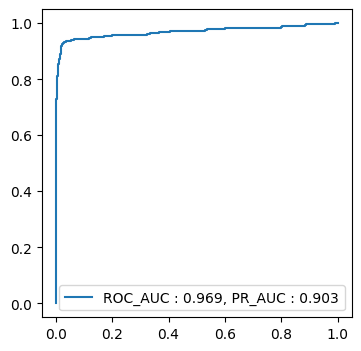

EPOCH: 189
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:50<00:00, 56.63it/s]


Train loss: 0.023047791935817356


100%|██████████| 6571/6571 [01:13<00:00, 89.73it/s] 


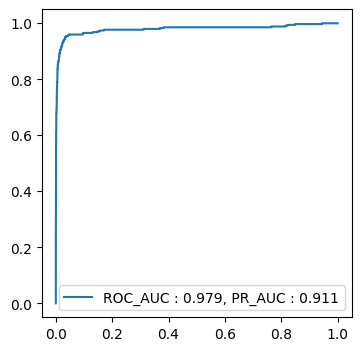

EPOCH: 190
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:50<00:00, 56.40it/s]


Train loss: 0.02512711657206001


100%|██████████| 6571/6571 [01:12<00:00, 90.81it/s] 


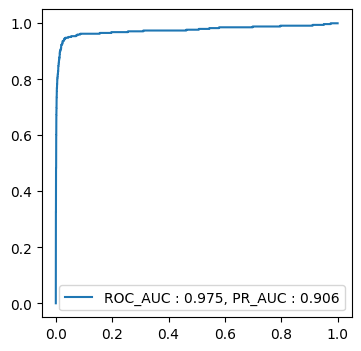

EPOCH: 191
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:50<00:00, 56.72it/s]


Train loss: 0.027023857696888573


100%|██████████| 6571/6571 [01:12<00:00, 90.37it/s] 


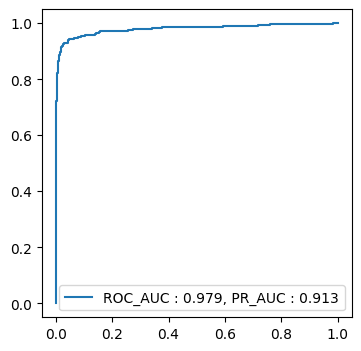

EPOCH: 192
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.29it/s]


Train loss: 0.023222851596654406


100%|██████████| 6571/6571 [01:11<00:00, 91.61it/s] 


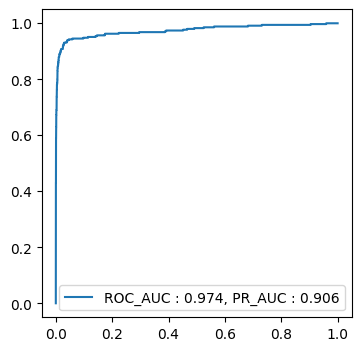

EPOCH: 193
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 55.93it/s]


Train loss: 0.022771390877009683


100%|██████████| 6571/6571 [01:11<00:00, 92.37it/s] 


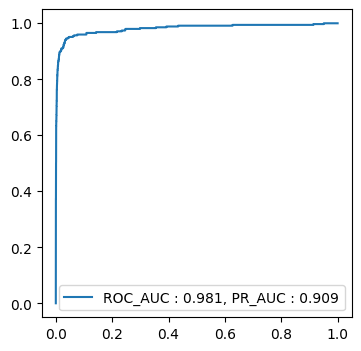

EPOCH: 194
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.17it/s]


Train loss: 0.02455027247364236


100%|██████████| 6571/6571 [01:10<00:00, 93.71it/s] 


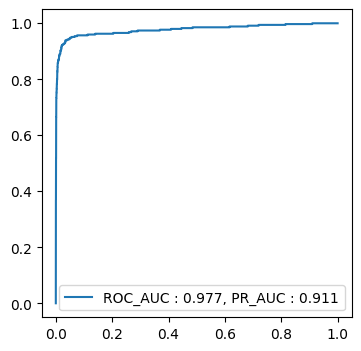

EPOCH: 195
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.13it/s]


Train loss: 0.02357528123776534


100%|██████████| 6571/6571 [01:10<00:00, 93.33it/s] 


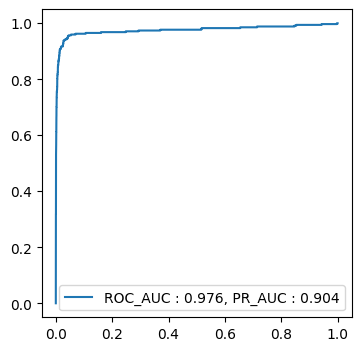

EPOCH: 196
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:52<00:00, 55.68it/s]


Train loss: 0.020421390768987316


100%|██████████| 6571/6571 [01:09<00:00, 94.21it/s] 


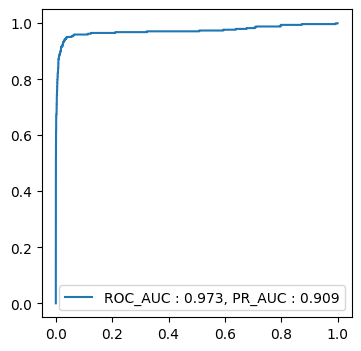

EPOCH: 197
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:50<00:00, 56.47it/s]


Train loss: 0.022259876944737297


100%|██████████| 6571/6571 [01:11<00:00, 91.90it/s] 


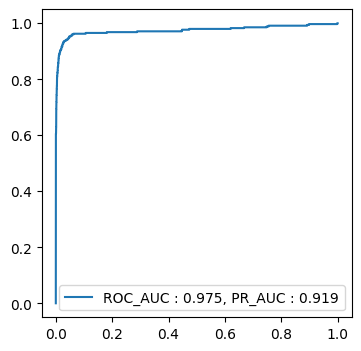

EPOCH: 198
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:51<00:00, 56.12it/s]


Train loss: 0.02387441462848189


100%|██████████| 6571/6571 [01:09<00:00, 94.08it/s] 


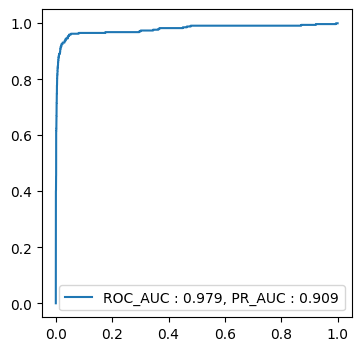

EPOCH: 199
Train dataloader len: 6260


100%|██████████| 6260/6260 [01:19<00:00, 79.19it/s]


Train loss: 0.02101647427073205


100%|██████████| 6571/6571 [00:32<00:00, 203.37it/s]


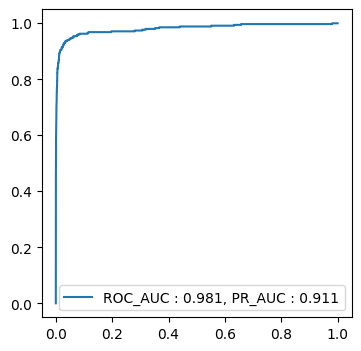

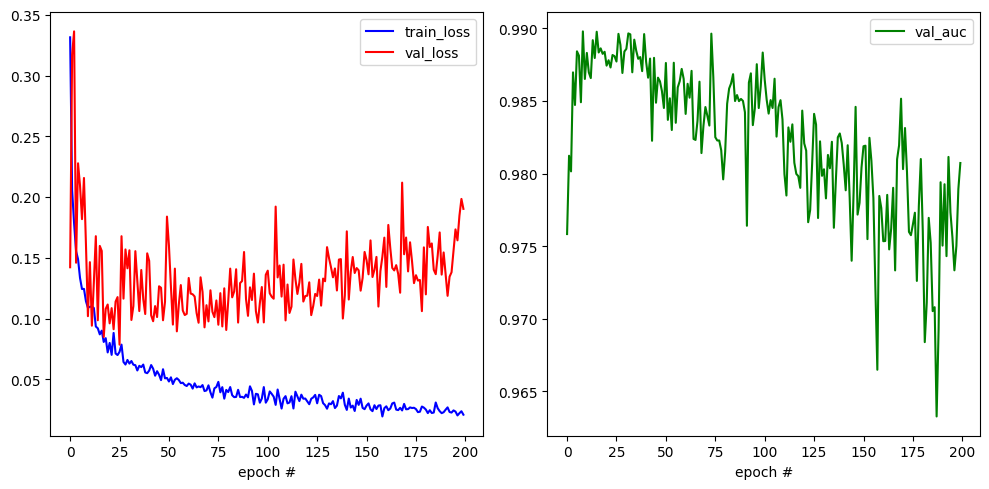

Max AUC in folds:  [0.9897977654271048]
Mean AUC:  0.9897977654271048


In [14]:
for n_experiment in range(conf_train.n_experiment):

    print('\n')
    print('\n')
    print(f'##################################################################')
    print(f'###################### RUN - {n_experiment} ######################')
    print(f'##################################################################')
    print('\n')
    print('\n')
    max_val_aucs_all_epoch = []

    for i in range(FOLD, FOLD+1):

        print(f'\n ############################ CV-Fold {i} - Balanced training ############################')

        seed_torch(n_experiment)

        print('\nInit loss function...', end=' ')
        
        loss_fn = nn.CrossEntropyLoss()
        print('Done!')

        print('\nInit Model...', end=' ')
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        

                
        model = HIPT_LGP_FC_STAGE3ONLY(conf_train.emb_dim, conf_train.nhead, conf_train.num_layers,
                                      conf_train.dropout_fc, conf_train.dropout_transformer, conf_train.dropout_attn).to(device)
        
        model.to(device)
        print('Done!')
        
        train_df = pd.read_csv(f'{conf_preproc["cv_split_dir_10fold"]}train_split_stratified_{i}.csv')
        val_df = pd.read_csv(f'{conf_preproc["cv_split_dir_10fold"]}val_split_stratified_{i}.csv')
        print('train_df shape:', train_df.shape, 'val_df.shape:', val_df.shape)
        
        n_classes=2        
        
        results_dir = conf_train.results_dir
        print("Results dir: ", results_dir)
        
        os.makedirs(results_dir, exist_ok=True)
        OmegaConf.save(config=OmegaConf.create(conf_train), f=results_dir+"conf_train.yaml")

        num_epochs = conf_train.num_epochs   
        batch_size = 1

        param_dict = train_loop( i, train_df.tb_positive.values, val_df.tb_positive.values, 
                                 results_dir, batch_size, num_epochs, model, n_classes, 
                                 loss_fn, gc=32)

        max_val_aucs_all_epoch.append( np.max(param_dict['val_auc_all_epoch']) )

        json_data = {'num_epochs': param_dict['num_epochs'],
                     'weight_decay': param_dict['weight_decay'],
                     'train_loss_all_epoch_cv': param_dict['train_loss_all_epoch'],
                     'val_loss_all_epoch_all_cv': param_dict['val_loss_all_epoch'],
                     'val_auc_all_epoch_all_cv': param_dict['val_auc_all_epoch'],
                     'min_val_loss': np.min(param_dict['val_loss_all_epoch']),
                     'max_val_auc': np.max(param_dict['val_auc_all_epoch'])}

        # Save training parameters to disk    
        with open(results_dir + f"cv_{i}/" 'test_params.json', 'w') as file:
            json.dump(json_data, file)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.plot(json_data['train_loss_all_epoch_cv'], "-b", label="train_loss")
        ax1.plot(json_data['val_loss_all_epoch_all_cv'], "-r", label="val_loss")
        ax1.set_xlabel('epoch #')
        ax1.legend()

        ax2.plot(json_data['val_auc_all_epoch_all_cv'], "-g", label="val_auc")
        ax2.set_xlabel('epoch #')
        ax2.legend()

        plt.tight_layout()
        plt.show()
        
    print('Max AUC in folds: ', max_val_aucs_all_epoch)
    print('Mean AUC: ', np.mean(max_val_aucs_all_epoch))